In [1]:
import pandas as pd
import sys
import numpy as np
import random
import math
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import itertools
import matplotlib.pyplot as plt
import csv
import json
import os
from os.path import isfile, join
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(df, dataset='hillstrom', verbose=True):
    # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
    #   as the target variable of interest and the selected treatment is 
    #   the e-mail campaign for women’s merchandise [1]
    # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods. 
    #    J Market Anal. 2014;2:218–238
    dataset = dataset.lower()
    if dataset in ('hillstrom', 'email'):
        columns = df.columns
        for col in columns:
            if df[col].dtype != object:
                continue
            df = pd.concat(
                    [df, pd.get_dummies(df[col], 
                                        prefix=col, 
                                        drop_first=False)],
                    axis=1)
            df.drop([col], axis=1, inplace=True)

        df.columns = [col.replace('-', '').replace(' ', '_').lower()
                      for col in df.columns]
        df = df[df.segment_mens_email == 0]
        df.index = range(len(df))
        df.drop(['segment_mens_email', 
                 'segment_no_email', 
                 'conversion', 
                 'spend'], axis=1, inplace=True)

        y_name = 'visit'
        t_name = 'segment_womens_email'
    elif dataset in ['criteo', 'ad']:
        df = df.fillna(0)
        y_name = 'y'
        t_name = 'treatment'
    elif dataset == 'lalonde':
        y_name = 'RE78'
        t_name = 'treatment'
    else:
        raise NotImplementedError
    
    df['Y'] = df[y_name]
    df.drop([y_name], axis=1, inplace=True)
    df['T'] = df[t_name]
    df.drop([t_name], axis=1, inplace=True)
    
    return df

In [3]:

def ty_assign(y, t):
    if y == 1 and t == 1:
        return "TR"
    elif y == 0 and t == 1:
        return "TN"
    elif y == 1 and t == 0:
        return "CR"
    elif y == 0 and t == 0:
        return "CN"
    else:
        return None


def t_assign(ty):
    if ty in ("TR", "TN"):
        return 1
    elif ty in ("CR", "CN"):
        return 0
    else:
        return None


def y_assign(ty):
    if ty in ("TR", "CR"):
        return 1
    elif ty in ("TN", "CN"):
        return 0
    else:
        return None


In [4]:

def tma(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    
    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        Dictionary: A dictionary of two models. One for the treatment group, 
            one for the control group.

            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }

    """
    
    treat_rows = (t == 1)
    control_rows = (t == 0)
    model_treat = method(**kwargs).fit(x[treat_rows], y[treat_rows])
    model_control = method(**kwargs).fit(x[control_rows], y[control_rows])
    
    res = {
        'model_treat': model_treat,
        'model_control': model_control,
    }
    return res


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        obj: A dictionary of two models. 
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        DataFrame: A dataframe with predicted returns for when the customers
            are treated and for when they are not treated.
    """
   
    if isinstance(obj['model_treat'], LinearRegression):
        pred_treat = obj['model_treat'].predict(newdata)
    else:
        pred_treat = obj['model_treat'].predict_proba(newdata)[:, 1]

    if isinstance(obj['model_control'], LinearRegression):
        pred_control = obj['model_control'].predict(newdata)
    else:
        pred_control = obj['model_control'].predict_proba(newdata)[:, 1]
    
    # pred_treat = obj['model_treat'].predict(newdata)
    # pred_control = obj['model_control'].predict(newdata)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df

In [5]:


def performance(pr_y1_t1, pr_y1_t0, y, t, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    
    Args:
        pr_y1_t1: the series (list) of the customer's expected return
        pr_y1_t0: the expected return when a customer is not treated
        y: the observed return of customers
        t: whther each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_t1': the number of treated responders
                'n_y1_t0': the number of not treated responders
                'r_y1_t1': the average return of treated customers
                'r_y1_t0': the average return of not treated customers
                'n_t1': the number of treated customers
                'n_t0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """
  
    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")
  
    ### check for NAs.
    if pr_y1_t1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t1")
    if pr_y1_t0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if t.isnull().values.any():
        raise Exception("uplift: NA not permitted in t")
   
    ### check valid values for y and t
    # if set(y) != {0, 1}:
    #     raise Exception("uplift: y must be either 0 or 1")
    if set(t) != {0, 1}:
        raise Exception("uplift: t must be either 0 or 1")

    ### check length of arguments
    if not (len(pr_y1_t1) == len(pr_y1_t0) == len(y) == len(t)):
        raise Exception("uplift: arguments pr_y1_t1, pr_y1_t0, y and t must all have the same length")

    ### define dif_pred
    dif_pred = pr_y1_t1 - pr_y1_t0
  
    ### Make index same
    y.index = dif_pred.index
    t.index = dif_pred.index
    
    mm = pd.DataFrame({
        'dif_pred': dif_pred,
        'y': y,
        't': t,
        'dif_pred_r': dif_pred.rank(ascending=False, method='first')
    })

    mm_groupby = mm.groupby(pd.qcut(mm['dif_pred_r'], groups, labels=range(1, groups+1), duplicates='drop'))
  
    n_y1_t1 = mm_groupby.apply(lambda r: r[r['t'] == 1]['y'].sum())
    n_y1_t0 = mm_groupby.apply(lambda r: r[r['t'] == 0]['y'].sum())
    n_t1 = mm_groupby['t'].sum()
    n_t0 = mm_groupby['t'].count() - n_t1
  
    df = pd.DataFrame({
        'n_t1': n_t1,
        'n_t0': n_t0,
        'n_y1_t1': n_y1_t1,
        'n_y1_t0': n_y1_t0,
        'r_y1_t1': n_y1_t1 / n_t1,
        'r_y1_t0': n_y1_t0 / n_t0,
    })
    fillna_columns = ['n_y1_t1', 'n_y1_t0', 'n_t1', 'n_t0']
    df[fillna_columns] = df[fillna_columns].fillna(0)
    df.index.name = 'groups'

    df['uplift'] = df['r_y1_t1'] - df['r_y1_t0']
    df['uplift'] = round(df['uplift'], 6)

    return df


def qini(perf, plotit=True):
    nrow = len(perf)

    # Calculating the incremental gains. 
    # - First, the cumulitative sum of the treated and the control groups are
    #  calculated with respect to the total population in each group at the
    #  specified decile
    # - Afterwards we calculate the percentage of the total amount of people
    #  (both treatment and control) are present in each decile
    cumul_y1_t1 = (perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()).fillna(0)
    cumul_y1_t0 = (perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()).fillna(0)
    deciles = [i/nrow for i in range(1, nrow+1)]

    ### Model Incremental gains
    inc_gains = (cumul_y1_t1 - cumul_y1_t0) * deciles
    inc_gains = [0.0] + list(inc_gains)

    ### Overall incremental gains
    overall_inc_gain = sum(perf['n_y1_t1']) / sum(perf['n_t1']) \
            - sum(perf['n_y1_t0']) / sum(perf['n_t0'])

    ### Random incremental gains
    random_inc_gains = [i*overall_inc_gain / nrow for i in range(nrow+1)]

    ### Compute area under the model incremental gains (uplift) curve
    x = [0] + deciles
    y = list(inc_gains)
    auuc = 0
    auuc_rand = 0

    auuc_list = [auuc]
    for i in range(1, len(x)):
        auuc += 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        auuc_list.append(auuc)

    ### Compute area under the random incremental gains curve
    y_rand = random_inc_gains

    auuc_rand_list = [auuc_rand]
    for i in range(1, len(x)):
        auuc_rand += 0.5 * (x[i] - x[i-1]) * (y_rand[i] + y_rand[i-1])
        auuc_rand_list.append(auuc_rand)

    ### Compute the difference between the areas (Qini coefficient)
    Qini = auuc - auuc_rand

    ### Plot incremental gains curve
    if plotit:
        x_axis = x
        plt.plot(x_axis, inc_gains)
        plt.plot(x_axis, random_inc_gains)
        plt.show()
    
    ### Qini 30%, Qini 10%
    n_30p = int(nrow*3/10)
    n_10p = int(nrow/10)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    res = {
        'qini': Qini,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }    

    return res

In [6]:
TestCase = 1

if(TestCase==1):
    df = pd.read_csv('Hillstrom.csv')
    dataset = 'hillstrom'
elif(TestCase==2):
    df = pd.read_csv('criteo_small.csv')
    dataset = 'criteo'
else:
    df = pd.read_csv('Lalonde.csv')
    dataset = 'lalonde'


df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
if(dataset != 'lalonde'):
    ty = pd.DataFrame({'Y': Y, 'T': T}).apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)

In [7]:
if dataset == 'hillstrom':
    fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
elif dataset == 'criteo':
    fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
elif dataset == 'lalonde':
    fold_gen = KFold(n_splits=5, shuffle=True, random_state=1234).split(X)

In [8]:
X.head()
len(X)

42693

In [9]:

for idx, (train_index, test_index) in enumerate(fold_gen):
    train_index = train_index
    test_index = test_index
    
X_train = X.reindex(train_index)
X_test = X.reindex(test_index)
if (dataset != 'lalonde'):
    Y = ty.apply(y_assign)
    T = ty.apply(t_assign)
Y_train = Y.reindex(train_index)
Y_test = Y.reindex(test_index)
T_train = T.reindex(train_index)
T_test = T.reindex(test_index)


In [10]:
len(X_test)

8536

In [11]:
mdl = tma(X_train, Y_train, T_train)

In [12]:
mdl

{'model_treat': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'model_control': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False)}

In [13]:
pred = predict_tma(mdl, X_test)

In [14]:
perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)

In [15]:
perf

,n_t1,n_t0,n_y1_t1,n_y1_t0,r_y1_t1,r_y1_t0,uplift
groups,,,,,,,
1,420,434,94,66,0.223810,0.152074,0.071736
2,438,416,75,54,0.171233,0.129808,0.041425
3,433,420,82,49,0.189376,0.116667,0.072710
4,448,406,78,41,0.174107,0.100985,0.073122
5,414,439,66,44,0.159420,0.100228,0.059192
6,422,432,47,31,0.111374,0.071759,0.039615
7,424,429,30,29,0.070755,0.067599,0.003156
8,423,431,55,40,0.130024,0.092807,0.037216
9,435,418,56,36,0.128736,0.086124,0.042611


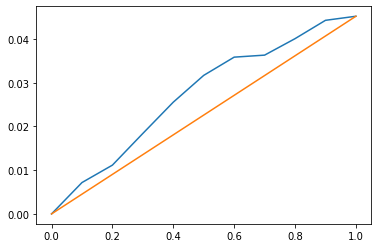

In [16]:
q = qini(perf)

In [17]:
q

{'qini': 0.00470693033901028,
 'inc_gains': [0.0,
  0.00717357910906298,
  0.011158645276292335,
  0.01840561854632617,
  0.025556343933432247,
  0.031685185002179594,
  0.03585248207485677,
  0.03631252980384142,
  0.040079823281287175,
  0.04427366590919488,
  0.0452063487880824],
 'random_inc_gains': [0.0,
  0.00452063487880824,
  0.00904126975761648,
  0.013561904636424722,
  0.01808253951523296,
  0.0226031743940412,
  0.027123809272849443,
  0.03164444415165768,
  0.03616507903046592,
  0.040685713909274154,
  0.0452063487880824],
 'auuc_list': [0,
  0.000358678955453149,
  0.0012752901747209147,
  0.0027535033658518393,
  0.004951601489839761,
  0.007813677936620352,
  0.01119056129047217,
  0.014798811884407079,
  0.018618429538663512,
  0.022836103998187612,
  0.027310104733051475],
 'auuc_rand_list': [0,
  0.000226031743940412,
  0.0009041269757616479,
  0.0020342856954637077,
  0.003616507903046592,
  0.0056507935985103,
  0.00813714278185483,
  0.011075555453080185,
  0.014

In [18]:

for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    if (dataset != 'lalonde'):
        Y = ty.apply(y_assign)
        T = ty.apply(t_assign)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)
    mdl = tma(X_train, Y_train, T_train)
    pred = predict_tma(mdl, X_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)



In [19]:
"""

        mdl = tma(X_train, Y_train, T_train)
        pred = predict_tma(mdl, X_test)
        print(pred)        
        # TODO: performance()
        # TODO: qini()

        ### Variable selection (General wrapper approach) ###

        ### Parameter tuning ###

#         print("Model: {}\n".format(model))
#         print("Tuning space: \n")
#         for key, val in search_space.items():
#             print("    '{}': {}\n".format(key, val))
#         print("Seed: {}\n".format(seed))
#         print("Qini value: mean = {}, std = {}\n\n".format(mean_qini, std_qini))

"""

'\n\n        mdl = tma(X_train, Y_train, T_train)\n        pred = predict_tma(mdl, X_test)\n        print(pred)        \n        # TODO: performance()\n        # TODO: qini()\n\n        ### Variable selection (General wrapper approach) ###\n\n        ### Parameter tuning ###\n\n#         print("Model: {}\n".format(model))\n#         print("Tuning space: \n")\n#         for key, val in search_space.items():\n#             print("    \'{}\': {}\n".format(key, val))\n#         print("Seed: {}\n".format(seed))\n#         print("Qini value: mean = {}, std = {}\n\n".format(mean_qini, std_qini))\n\n'